In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def sample_x0_cloud(batch_size: int, n_points: int = N_POINTS):
    # one label for entire cloud
    mix = torch.bernoulli(0.5 * torch.ones(batch_size, device=device))  # (B,)
    
    # assign whole cloud to cluster 1 or 2
    mu_cloud = torch.where(
        mix[:, None, None] == 1,
        mu1_single, 
        mu2_single
    )  # (B,1,3)

    eps = torch.randn(batch_size, n_points, 3, device=device)
    x0 = mu_cloud + eps    # (B,N,3)

    return x0



In [25]:
# ===========================
# Fourier time embedding
# ===========================
class FourierTimeEmbedding(nn.Module):
    def __init__(self, dim=64, max_freq=1000.0):
        super().__init__()
        self.freqs = torch.exp(
            torch.linspace(0, math.log(max_freq), dim//2)
        )

    def forward(self, t):
        t_norm = t.float() / float(T)
        args = t_norm.unsqueeze(-1) * self.freqs.to(t.device)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

# ===========================
# EGNN Layer
# ===========================
class EGNNLayer(nn.Module):
    def __init__(self, time_dim=64, hidden_dim=64):
        super().__init__()
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim*2 + 1 + time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, hidden_dim),
            nn.SiLU()
        )
        
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )
        
    def forward(self, x, h, t_emb):
        B, N, _ = x.shape
        
        diff = x.unsqueeze(2) - x.unsqueeze(1)  # (B, N, N, 3)
        r2 = (diff**2).sum(dim=-1, keepdim=True)
        
        # expand features
        h_i = h.unsqueeze(2).expand(-1, -1, N, -1)
        h_j = h.unsqueeze(1).expand(-1, N, -1, -1)
        
        t_in = t_emb.unsqueeze(1).unsqueeze(2).expand(B, N, N, -1)
        
        edge_in = torch.cat([h_i, h_j, r2, t_in], dim=-1)
        e_ij = self.edge_mlp(edge_in)
        
        # coordinate update
        w_ij = self.coord_mlp(e_ij)
        dx = (w_ij * diff).sum(dim=2)
        x = x + dx
        
        # feature update
        m_i = e_ij.sum(dim=2)
        h = self.node_mlp(torch.cat([h, m_i], dim=-1))
        
        return x, h


# ===========================
# EGNN model: predicts eps (noise), not x0
# ===========================
class EGNN_Eps(nn.Module):
    def __init__(self, n_layers=3, time_dim=64, hidden_dim=64):
        super().__init__()
        
        self.t_emb = FourierTimeEmbedding(time_dim)
        
        # node feature init: [x_t, t_emb] -> h
        self.node_mlp = nn.Sequential(
            nn.Linear(3 + time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.layers = nn.ModuleList([
            EGNNLayer(time_dim=time_dim, hidden_dim=hidden_dim)
            for _ in range(n_layers)
        ])

        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3)   # -> eps_hat (B,N,3)
        )

    def forward(self, x_t, t):
        B, N, _ = x_t.shape
        t_emb = self.t_emb(t)  # (B, time_dim)

        # 初始 node feature：你剛問的那句 h_i = MLP([x_t_i, t_emb]) 就在這裡
        h = self.node_mlp(torch.cat([
            x_t,
            t_emb.unsqueeze(1).expand(B, N, -1)
        ], dim=-1))   # (B, N, hidden_dim)

        x = x_t
        for layer in self.layers:
            x, h = layer(x, h, t_emb)

        # 輸出 eps_hat
        eps_hat = self.out_mlp(torch.cat([x, h], dim=-1))
        return eps_hat

model = EGNN_Eps().to(device)



In [26]:
# ===========================
# Loss: predict eps (noise)
# ===========================
def loss_eps(model, batch_size):
    x0 = sample_x0_cloud(batch_size)   # (B,N,3)

    # 避免太小的 t（小 noise 很不穩），取 0.2T ~ T
    t = torch.randint(int(0.2 * T), T, (batch_size,), device=device)

    alpha_bar_t = alpha_bar[t].view(-1,1,1)
    sigma_t     = sigmas[t].view(-1,1,1)

    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_bar_t)*x0 + sigma_t*eps

    eps_hat = model(x_t, t)

    return ((eps_hat - eps)**2).mean()


# ===========================
# Diffusion schedule
# ===========================
T = 200
beta_start = 1e-4
beta_end   = 2e-2
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)
sigmas = torch.sqrt(1.0 - alpha_bar)

# ===========================
# Data: mixture Gaussian (3D)
# ===========================
mu1_single = torch.tensor([+2.0, 0.0, 0.0], device=device)  # cluster 1
mu2_single = torch.tensor([-2.0, 0.0, 0.0], device=device)  # cluster 2


N_POINTS = 32
# ===========================
# Training loop
# ===========================
batch_size = 8
lr = 2e-4
num_steps = 2000

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=50,    # ← 比較敏感；EGNN 推薦 20~50
    cooldown=20,    # ← 快比較好
    min_lr=1e-6,
    threshold=1e-3  # ← 不要求太小的 improvement
)

loss_history_1 = []

model.train()
for step in range(1, num_steps+1):
    loss = loss_eps(model, batch_size)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss.item())

    loss_history_1.append(loss.item())

    if step % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"step {step:5d} | loss={loss.item():.4f} | Lr={current_lr:.6f}")


step    10 | loss=2854.9824 | Lr=0.000200
step    20 | loss=26.5791 | Lr=0.000200
step    30 | loss=0.9974 | Lr=0.000200
step    40 | loss=1.2322 | Lr=0.000200
step    50 | loss=1.1929 | Lr=0.000200
step    60 | loss=1.1053 | Lr=0.000200
step    70 | loss=1.0212 | Lr=0.000200
step    80 | loss=0.8602 | Lr=0.000200
step    90 | loss=0.7936 | Lr=0.000200
step   100 | loss=0.8074 | Lr=0.000200
step   110 | loss=0.5949 | Lr=0.000200
step   120 | loss=0.7649 | Lr=0.000200
step   130 | loss=0.5928 | Lr=0.000200
step   140 | loss=0.6889 | Lr=0.000200
step   150 | loss=0.5105 | Lr=0.000200
step   160 | loss=0.9519 | Lr=0.000200
step   170 | loss=0.5036 | Lr=0.000200
step   180 | loss=0.6514 | Lr=0.000200
step   190 | loss=0.6113 | Lr=0.000200
step   200 | loss=0.4999 | Lr=0.000200
step   210 | loss=0.4318 | Lr=0.000200
step   220 | loss=0.5510 | Lr=0.000200
step   230 | loss=0.6148 | Lr=0.000200
step   240 | loss=0.5433 | Lr=0.000200
step   250 | loss=0.5137 | Lr=0.000100
step   260 | loss=0.4

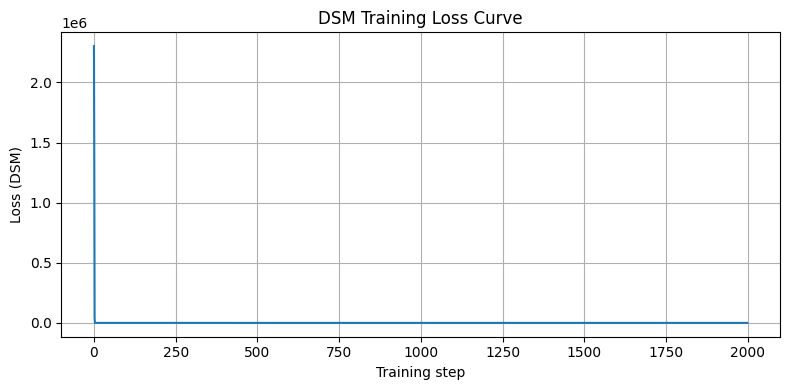

In [23]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history_1)

## 試著做做看 validation loss

In [27]:
@torch.no_grad()
def val_loss_x0(model, batch_size):
    x0 = sample_x0_cloud(batch_size)
    t = torch.randint(int(0.1*T), T, (batch_size,), device=device)

    alpha_bar_t = alpha_bar[t].view(-1,1,1)
    sigma_t     = sigmas[t].view(-1,1,1)

    eps = torch.randn_like(x0)
    x_t = torch.sqrt(alpha_bar_t)*x0 + sigma_t*eps

    x0_hat = model(x_t, t)

    return ((x0_hat - x0)**2).mean().item()

if step % 500 == 0:
    vloss = val_loss_x0(model, batch_size)
    print(f"[VAL] step {step} | val_loss={vloss:.4f}")


[VAL] step 2000 | val_loss=2.0020


## Reverse Diffusion

In [28]:
@torch.no_grad()
def reverse_sample_eps(model, num_samples=200, n_points=32):
    model.eval()

    x = torch.randn(num_samples, n_points, 3, device=device)

    for t_idx in reversed(range(1, T)):
        t = torch.full((num_samples,), t_idx, device=device, dtype=torch.long)

        eps_hat = model(x, t)  # (B,N,3)

        beta_t      = betas[t_idx]
        alpha_t     = alphas[t_idx]
        alpha_bar_t = alpha_bar[t_idx]

        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)

        # DDPM mean for point cloud
        x0_pred = (x - coef2 * eps_hat) / torch.sqrt(alpha_t)
        mean = coef1 * (x - coef2 * eps_hat)

        # DDPM variance term
        beta_tilde = beta_t * (1 - alpha_bar[t_idx-1]) / (1 - alpha_bar_t)
        noise = torch.randn_like(x)

        x = mean + torch.sqrt(beta_tilde) * noise

    return x.cpu()


## Visualization

In [29]:
import matplotlib.pyplot as plt

def plot_scatter_2d_pc(samples):
    # samples: (B, N, 3)
    pc = samples.reshape(-1, 3)   # (B*N, 3)

    x = pc[:, 0]
    y = pc[:, 1]

    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=8, alpha=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Reverse Diffusion: Point Cloud Scatter (all points)")
    plt.grid(True)
    plt.show()


In [30]:
def plot_histogram_x_pc(samples):
    pc = samples.reshape(-1, 3)   # (B*N, 3)
    x = pc[:, 0]

    plt.figure(figsize=(6,4))
    plt.hist(x, bins=40, density=True, alpha=0.7)
    plt.xlabel("x")
    plt.title("Histogram of x (point cloud mixture)")
    plt.grid(True)
    plt.show()


In [35]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def plot_kde_heatmap_pc(samples):
    pc = samples.reshape(-1, 3)
    x = pc[:, 0]
    y = pc[:, 1]

    # ⭐ convert tensor → float
    xmin = float(x.min()) - 1
    xmax = float(x.max()) + 1
    ymin = float(y.min()) - 1
    ymax = float(y.max()) + 1

    # grid
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values    = np.vstack([x.cpu().numpy(), y.cpu().numpy()])  # ⭐ KDE 要 numpy

    # KDE
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, f, levels=60, cmap="viridis")
    plt.title("KDE Heatmap (point cloud)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


In [36]:
from mpl_toolkits.mplot3d import Axes3D
def plot_scatter_3d_pc(samples):
    pc = samples.reshape(-1, 3)
    x = pc[:, 0]
    y = pc[:, 1]
    z = pc[:, 2]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, s=5, alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.title("3D Scatter of Point Cloud Samples")
    plt.show()



In [37]:
samples = reverse_sample_eps(model, num_samples=32)#, n_points=1)
print(samples.shape)


torch.Size([32, 32, 3])


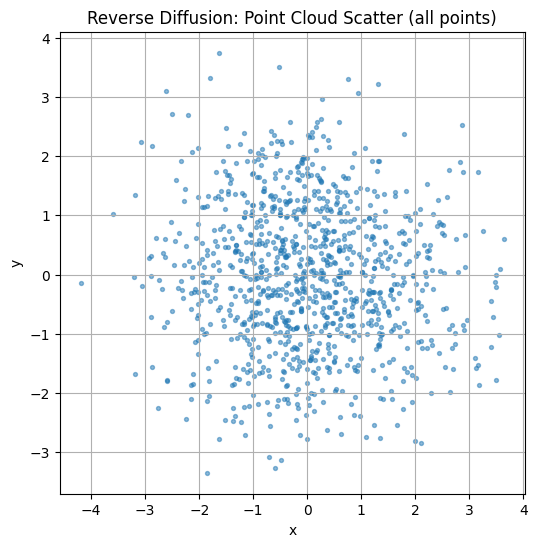

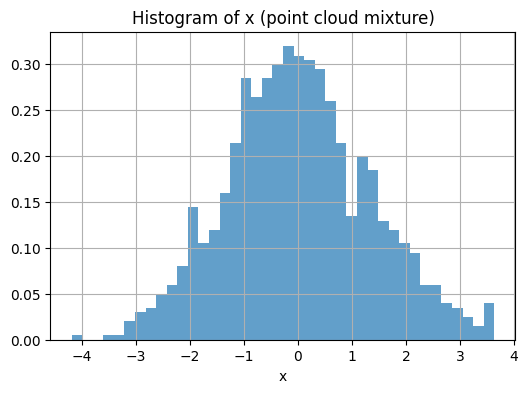

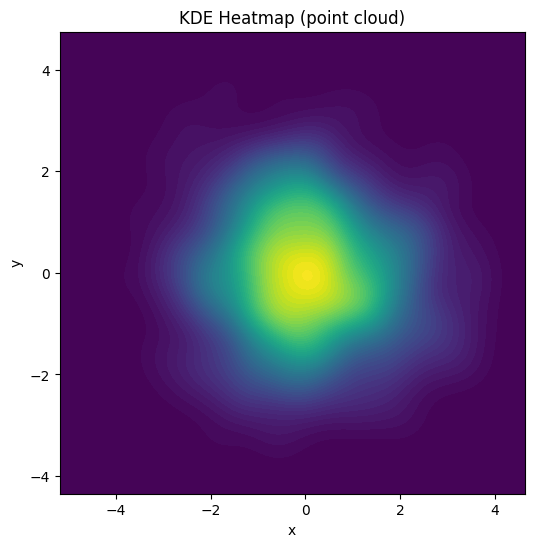

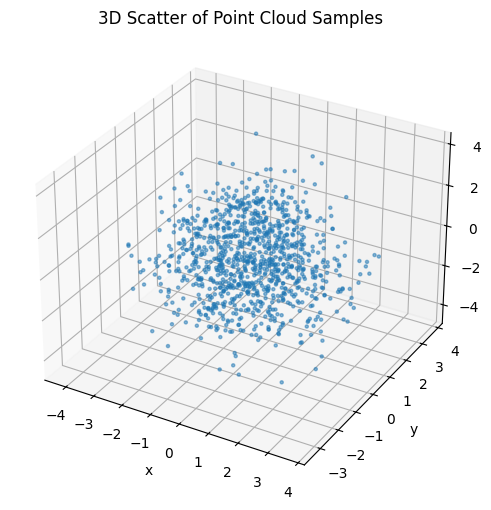

In [38]:
plot_scatter_2d_pc(samples)
plot_histogram_x_pc(samples)
plot_kde_heatmap_pc(samples)
plot_scatter_3d_pc(samples)